In [1]:
import numpy as np

In [1]:
from arguments import get_args 
import os
import torch 
from data.dataClass import MemotionDatasetForCmml
from model.CmmlLayer import CmmlModel
# from model.eman import EMAN
import torch.optim as optim 
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from torch.utils.data import DataLoader 
import datetime 
import numpy as np
from test_func import test_multilabel
from tqdm import tqdm
from loss import focal_binary_cross_entropy, diversity_measurement, consistency_measurement
from loss import focal_binary_cross_entropy,zlpr_loss,AsymmetricLoss,ResampleLoss 
import torch.nn as nn
import wandb
import random
from matplotlib import pyplot as plt
import torch.nn as nn
from utils.plot_utils import get_confusion_matrix
from torch.cuda.amp import autocast, GradScaler
import clip
import open_clip
from model.clip_info import clip_nms,clip_dim

from model.utils import LARS,adjust_learning_rate,exclude_bias_and_norm
from ORG import GB_estimate 
from copy import deepcopy 
import gc 
from data.semi_supervised_data import *
from utils.npy_save import npy_save_txt

from model.dualstream_net import CmmlModel_v2
from model.deep_weak_attention import deep_weak_attention
from model.AutoEncoder import AutoEncoder, ModelCombineAE
from pretrain import train_auto_encoder
from test_func import test_auto_encoder, test_multilabel_finetune
from data.create_freq_file import dump_freq_data

[nltk_data] Downloading package punkt to /home/fptu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
image_features_path = '../data/MAMI_processed/clip_features/train/image_feature.txt'
text_features_path = '../data/MAMI_processed/clip_features/train/text_feature.txt'

In [3]:
image_features_arr = np.loadtxt(image_features_path)
text_features_arr = np.loadtxt(text_features_path)

In [7]:
image_features_arr.mean(axis=0)

array([ 3.15971411e-01, -2.73896088e-01,  1.08587330e-01, -3.96654901e-01,
       -2.25709136e-01, -3.55737077e-02,  1.99839442e-01, -7.25399535e-02,
        1.21804638e-01, -1.60316729e-01, -1.39442906e-01, -8.57983875e-03,
       -1.25196964e-02,  2.20489040e-02, -2.42871104e-03, -4.24859888e-02,
       -1.76166482e-01,  4.38027239e-02,  1.41366172e-01, -1.32549231e-01,
       -8.22782278e-02,  1.57752763e-01,  1.25467344e-02, -4.20296508e-02,
       -2.13129874e-01, -2.60056600e-01,  1.19172583e-01, -1.04336464e-01,
        1.89417499e-01,  2.51140087e-01,  4.06654724e-02, -1.54392667e-01,
       -3.00699283e-01, -1.08879493e-01,  2.20260563e-01,  1.31015386e-01,
       -1.48646359e-01, -2.52970164e-01,  8.89098179e-02, -9.21372765e-02,
       -3.24448163e-02,  2.41669547e-01, -2.04563643e-01,  1.54550554e-01,
        1.75584129e-01,  1.30232794e-01, -2.10052751e-01, -6.61435812e-02,
        3.59007222e-02, -1.84188656e-01, -1.52934278e-01, -7.43461556e-02,
        1.22348661e-03,  

In [8]:
image_features_arr.std(axis=0)

array([0.45969488, 0.53511727, 0.44186024, 0.56989808, 0.44545101,
       0.41285957, 0.4334057 , 0.40955458, 0.42794695, 0.47379211,
       0.41225422, 0.4812985 , 0.42798703, 0.45099249, 0.49212471,
       0.45035826, 0.55904088, 0.46023818, 0.43957939, 0.44891069,
       0.46037579, 0.43345684, 0.49186913, 0.45678145, 0.62737694,
       0.44514941, 0.43978883, 0.48204809, 0.50004382, 0.46212227,
       0.49985209, 0.41771062, 0.45572249, 0.448606  , 0.45214502,
       0.46312754, 0.43482385, 0.42360553, 0.44630062, 0.5048433 ,
       0.44041811, 0.43843723, 0.4604982 , 0.43938858, 0.43659859,
       0.42998278, 0.48023813, 0.44267447, 0.44571345, 0.46079659,
       0.43473936, 0.43805319, 0.45568431, 0.45988977, 0.43038459,
       0.41806989, 0.48133074, 0.44183892, 0.42747501, 0.44745136,
       0.42284998, 0.42951264, 0.42598232, 0.4791184 , 0.46336238,
       0.46878003, 0.47213667, 0.44977518, 0.42945372, 0.47343923,
       0.42381414, 0.42185466, 0.44101649, 0.41628494, 0.42889

In [9]:
text_features_arr.mean(axis=0)

array([ 4.52129377e-02, -9.14346579e-02,  8.76827295e-02,  3.14918611e-02,
        6.38137116e-03, -3.68660117e-02, -1.01524399e-01,  6.76655243e-02,
       -3.33949944e-03, -4.02371672e-02,  9.77993194e-02,  5.09163062e-02,
        4.86585716e-02,  9.04049790e-02,  6.34182604e-02, -5.47400941e-02,
       -3.17985017e-02, -2.82640423e-02,  6.66407100e-02, -1.28362584e-02,
       -1.90396559e-01,  4.53290100e-02,  6.52462108e-02, -3.11251408e-02,
        1.43537270e-01,  5.33702868e-02,  3.70399961e-02, -9.53391506e-03,
       -6.32417391e-02,  1.16553547e-01,  4.57924314e-02, -2.19957096e-01,
        2.21062021e-03,  5.97643339e-03,  1.06999168e-02,  2.82281382e-03,
        2.58958928e-04, -7.66098171e-02, -2.35002489e-02,  3.81194819e-03,
       -4.04395145e-02,  6.26822169e-02, -7.49989599e-02,  5.95697130e-02,
        1.65543964e-01, -8.62189510e-02, -1.43844357e-01,  1.20822191e-02,
        6.92749080e-02, -9.48530198e-02,  1.46511029e-01,  6.70215656e-03,
       -1.09925882e-01, -

In [10]:
text_features_arr.std(axis=0)

array([0.37769933, 0.42252631, 0.3401002 , 0.47080234, 0.33333062,
       0.3435073 , 0.35967565, 0.33997339, 0.34237161, 0.34295083,
       0.35689523, 0.35921778, 0.3477962 , 0.32796661, 0.37733835,
       0.35420712, 0.41413298, 0.36101579, 0.34905059, 0.36347825,
       0.34968758, 0.33520138, 0.36007424, 0.33392602, 0.4408495 ,
       0.35206378, 0.34600203, 0.35653086, 0.42775396, 0.36306995,
       0.37746482, 0.3391713 , 0.35559868, 0.33078341, 0.37368828,
       0.34759538, 0.34858513, 0.31856252, 0.33309954, 0.36588046,
       0.34362076, 0.34606508, 0.36854473, 0.34705072, 0.35559072,
       0.35094874, 0.3545264 , 0.34538891, 0.33936904, 0.36797614,
       0.37177137, 0.3465045 , 0.3612046 , 0.35511789, 0.34954941,
       0.34204708, 0.36434911, 0.34871772, 0.35923918, 0.35422098,
       0.33781189, 0.34615318, 0.34152789, 0.32604279, 0.3583648 ,
       0.34820938, 0.36169318, 0.36647626, 0.36525504, 0.36463655,
       0.33940593, 0.36151798, 0.32797787, 0.33412996, 0.32737

In [6]:
parser = pd.Series()
parser = pd.concat([parser, pd.Series({'text_col': "Text Transcription"})])
parser = pd.concat([parser, pd.Series({'batchsize': 80})])
parser = pd.concat([parser, pd.Series({'use_augmentation': True})])
parser = pd.concat([parser, pd.Series({'use_clip': True})])
parser = pd.concat([parser, pd.Series({'use_open_clip': False})])
parser = pd.concat([parser, pd.Series({'input_file_clip_extractor': '../data/MAMI_processed/train.csv'})])
parser = pd.concat([parser, pd.Series({'input_img_dir_clip_extractor': '../data/MAMI_processed/images/train'})])
parser = pd.concat([parser, pd.Series({'clip_model': 'vit14'})])
parser = pd.concat([parser, pd.Series({'use_gpu': True})])
parser = pd.concat([parser, pd.Series({'visible_gpu': '0'})])
parser = pd.concat([parser, pd.Series({'pretrain_auto_encoder': True})])

args = parser
args

/tmp/ipykernel_969313/171287614.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  parser = pd.Series()


text_col                                         Text Transcription
batchsize                                                        80
use_augmentation                                               True
use_clip                                                       True
use_open_clip                                                 False
input_file_clip_extractor          ../data/MAMI_processed/train.csv
input_img_dir_clip_extractor    ../data/MAMI_processed/images/train
clip_model                                                    vit14
use_gpu                                                        True
visible_gpu                                                       0
pretrain_auto_encoder                                          True
dtype: object

In [7]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

if args.use_gpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = args.visible_gpu
    cuda = torch.cuda.is_available() and args.use_gpu
else:
    cuda = False


label_cols = ['shaming', 'stereotype', 'objectification', 'violence']
train_supervise_path = '../data/MAMI_processed/train_labeled_ratio-0.05.csv'
train_supervise_image_feature_path = '../data/MAMI_processed/clip_features/train_labeled_ratio-0.05/image_feature.txt'
train_supervise_text_feature_path = '../data/MAMI_processed/clip_features/train_labeled_ratio-0.05/text_feature.txt'

unsupervise_image_feature_path = '../data/MAMI_processed/clip_features/train/image_feature.txt'
unsupervise_text_feature_path = '../data/MAMI_processed/clip_features/train/text_feature.txt'

# feature_stats = compute_feature_stats(unsupervise_image_feature_path, unsupervise_text_feature_path)

unsupervised_pretrain_loader = create_dataloader_pre_extracted(args,
                                                            image_features_path=unsupervise_image_feature_path,
                                                            text_features_path=unsupervise_text_feature_path,
                                                            shuffle=True, batch_size=args.batchsize, 
                                                            # normalize=True, feature_stats=feature_stats
                                                            )

finetune_supervised_loader = create_dataloader_pre_extracted(args,
                                                            image_features_path=train_supervise_image_feature_path,
                                                            text_features_path=train_supervise_text_feature_path,
                                                            is_labeled=True, label_path=train_supervise_path, label_cols=label_cols,
                                                            shuffle=True, batch_size=args.batchsize,
                                                            # normalize=True, feature_stats=feature_stats
                                                            )       

val_loader = create_dataloader_pre_extracted(args,
                                            image_features_path='../data/MAMI_processed/clip_features/val/image_feature.txt',
                                            text_features_path='../data/MAMI_processed/clip_features/val/text_feature.txt',
                                            is_labeled=True, label_path='../data/MAMI_processed/val.csv', label_cols=label_cols,
                                            shuffle=False, batch_size=args.batchsize,
                                            # normalize=True, feature_stats=feature_stats
                                            )

test_loader = create_dataloader_pre_extracted(args,
                                            image_features_path='../data/MAMI_processed/clip_features/test/image_feature.txt',
                                            text_features_path='../data/MAMI_processed/clip_features/test/text_feature.txt',
                                            is_labeled=True, label_path='../data/MAMI_processed/test.csv', label_cols=label_cols,
                                            shuffle=False, batch_size=args.batchsize,
                                            # normalize=True, feature_stats=feature_stats
                                            )

# if args.use_resample_loss:
#     args.freq_file = dump_freq_data(train_supervise_path, label_cols)

if args.pretrain_auto_encoder:
    image_ae = AutoEncoder(encode_image=True)
    text_ae = AutoEncoder(encode_text=True)
    if cuda:
        image_ae.cuda()
        text_ae.cuda()

    list_train_loss, list_val_loss = train_auto_encoder(image_ae, unsupervised_pretrain_loader, val_loader, cuda=cuda, verbose=3)
    test_loss = test_auto_encoder(image_ae, test_loader)
    print()
    print(test_loss)

    list_train_loss, list_val_loss = train_auto_encoder(text_ae, unsupervised_pretrain_loader, val_loader, cuda=cuda, verbose=3)
    test_loss = test_auto_encoder(text_ae, test_loader)
    print()
    print(test_loss)        

============== Pretrain Auto Encoder ==================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 951.89it/s]


Epoch: 1 - Train Loss: 0.194466
Epoch: 1 - Valid Loss: 0.148812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 984.86it/s]


Epoch: 4 - Train Loss: 0.124610
Epoch: 4 - Valid Loss: 0.127716


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 664.08it/s]


Epoch: 7 - Train Loss: 0.113934
Epoch: 7 - Valid Loss: 0.121985


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 662.23it/s]


Epoch: 10 - Train Loss: 0.108194
Epoch: 10 - Valid Loss: 0.119735


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1047.98it/s]


Epoch: 13 - Train Loss: 0.104371
Epoch: 13 - Valid Loss: 0.118457


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 943.39it/s]


Epoch: 16 - Train Loss: 0.101578
Epoch: 16 - Valid Loss: 0.117885


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 449.63it/s]


Epoch: 19 - Train Loss: 0.099442
Epoch: 19 - Valid Loss: 0.117554


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 640.88it/s]


Epoch: 22 - Train Loss: 0.097761
Epoch: 22 - Valid Loss: 0.117277


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 531.81it/s]


Epoch: 25 - Train Loss: 0.096415
Epoch: 25 - Valid Loss: 0.117148


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 607.56it/s]


Epoch: 28 - Train Loss: 0.095314
Epoch: 28 - Valid Loss: 0.117108


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 734.19it/s]


Epoch: 31 - Train Loss: 0.094422
Epoch: 31 - Valid Loss: 0.117077


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1031.05it/s]


Epoch: 34 - Train Loss: 0.093659
Epoch: 34 - Valid Loss: 0.117051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 874.54it/s]


Epoch: 37 - Train Loss: 0.093047
Epoch: 37 - Valid Loss: 0.117052


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 925.54it/s]


Epoch: 40 - Train Loss: 0.092519
Epoch: 40 - Valid Loss: 0.117048


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 572.16it/s]


Epoch: 43 - Train Loss: 0.092075
Epoch: 43 - Valid Loss: 0.117078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 451.44it/s]


Epoch: 46 - Train Loss: 0.091706
Epoch: 46 - Valid Loss: 0.117051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 906.91it/s]


Epoch: 49 - Train Loss: 0.091393
Epoch: 49 - Valid Loss: 0.117076


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 927.53it/s]



0.11590530436772567
============== Pretrain Auto Encoder ==================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 977.37it/s]


Epoch: 1 - Train Loss: 0.258725
Epoch: 1 - Valid Loss: 0.213025


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 819.53it/s]


Epoch: 4 - Train Loss: 0.176361
Epoch: 4 - Valid Loss: 0.182677


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 698.93it/s]


Epoch: 7 - Train Loss: 0.162419
Epoch: 7 - Valid Loss: 0.175783


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 998.23it/s]


Epoch: 10 - Train Loss: 0.155488
Epoch: 10 - Valid Loss: 0.173283


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 776.08it/s]


Epoch: 13 - Train Loss: 0.151012
Epoch: 13 - Valid Loss: 0.172029


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1049.45it/s]


Epoch: 16 - Train Loss: 0.147834
Epoch: 16 - Valid Loss: 0.171370


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 658.72it/s]


Epoch: 19 - Train Loss: 0.145366
Epoch: 19 - Valid Loss: 0.170967


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 884.40it/s]


Epoch: 22 - Train Loss: 0.143430
Epoch: 22 - Valid Loss: 0.170754


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 556.73it/s]


Epoch: 25 - Train Loss: 0.141867
Epoch: 25 - Valid Loss: 0.170672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 498.45it/s]


Epoch: 28 - Train Loss: 0.140593
Epoch: 28 - Valid Loss: 0.170656


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 693.46it/s]


Epoch: 31 - Train Loss: 0.139555
Epoch: 31 - Valid Loss: 0.170602


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 795.36it/s]


Epoch: 34 - Train Loss: 0.138692
Epoch: 34 - Valid Loss: 0.170601


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 599.96it/s]


Epoch: 37 - Train Loss: 0.137971
Epoch: 37 - Valid Loss: 0.170598


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1036.42it/s]


Epoch: 40 - Train Loss: 0.137360
Epoch: 40 - Valid Loss: 0.170581


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1092.52it/s]


Epoch: 43 - Train Loss: 0.136855
Epoch: 43 - Valid Loss: 0.170587


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1031.25it/s]


Epoch: 46 - Train Loss: 0.136422
Epoch: 46 - Valid Loss: 0.170609


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 729.94it/s]


Epoch: 49 - Train Loss: 0.136052
Epoch: 49 - Valid Loss: 0.170596


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 546.48it/s]


0.17556986441979042


In [9]:
train_image_features_arr = np.loadtxt(unsupervise_image_feature_path)
train_text_features_arr = np.loadtxt(unsupervise_text_feature_path)

In [20]:
## Check for multicollinearity

with torch.no_grad():
    image_encoded = image_ae.encoder(Tensor(train_image_features_arr).cuda())
    text_encoded = text_ae.encoder(Tensor(train_text_features_arr).cuda())

print(image_encoded)
print(text_encoded)

# calculate peason r

image_norm = image_encoded - image_encoded.mean(axis=0)
text_norm = text_encoded - text_encoded.mean(axis=0)

numerator = image_norm.T @ text_norm
denominator = torch.linalg.norm(image_norm, dim=0).unsqueeze(-1) @ torch.linalg.norm(text_norm, dim=0).unsqueeze(0)

corr = (numerator/denominator).cpu().numpy()
corr



tensor([[ 1.1480,  0.4273, -0.3760,  ..., -0.3785,  0.0594,  0.5411],
        [ 0.3236,  0.6255,  0.1821,  ..., -0.7852,  0.4899,  0.5160],
        [ 0.2061,  0.6350, -0.2619,  ..., -0.5540,  0.0034,  0.7859],
        ...,
        [-0.7613,  0.4843,  0.0868,  ..., -0.1540,  0.8473,  0.6214],
        [ 0.8856,  0.8061, -0.0081,  ..., -0.1752,  0.7930, -0.0236],
        [ 0.3121,  0.3401,  0.2369,  ..., -0.9752,  0.3237,  0.1789]],
       device='cuda:0')
tensor([[ 4.0100e-06,  8.7535e-01,  1.3348e-01,  ...,  1.4212e+00,
          1.0146e+00,  1.7027e-01],
        [ 1.8584e-01,  7.6139e-01,  6.5118e-01,  ..., -2.0526e-01,
          8.1267e-01,  1.1071e+00],
        [ 3.0000e-01, -4.9062e-02,  2.7698e-02,  ...,  4.5169e-01,
          7.3432e-01,  8.0406e-01],
        ...,
        [ 4.7940e-01,  1.0391e-01,  4.9450e-01,  ..., -1.0210e+00,
          4.4758e-01,  5.6908e-01],
        [ 2.4348e-01,  5.8145e-01,  2.3690e-01,  ..., -5.0024e-01,
          4.3682e-01,  5.3078e-01],
        [-1.80

array([[ 0.05345062,  0.18876258,  0.02575023, ..., -0.04843659,
         0.11109787,  0.10598236],
       [-0.02649296,  0.12798715,  0.0248415 , ..., -0.01173797,
         0.13173723, -0.03096728],
       [-0.11566342,  0.01766953,  0.0501775 , ..., -0.07122613,
         0.06638262, -0.03418166],
       ...,
       [ 0.03338503,  0.09079733, -0.02362076, ...,  0.09597161,
         0.16276024, -0.07114988],
       [-0.07284309,  0.04725042,  0.0237659 , ...,  0.01313911,
        -0.15112193, -0.02904417],
       [ 0.02117893, -0.2274241 , -0.14338924, ..., -0.0402692 ,
        -0.22607538,  0.09443286]], dtype=float32)

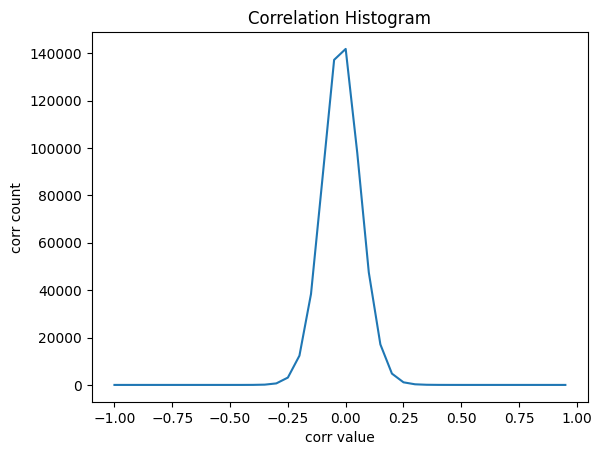

In [23]:
histogram, bin_edges = np.histogram(corr, bins=40, range=(-1, 1))

# configure and draw the histogram figure
plt.figure()
plt.title("Correlation Histogram")
plt.xlabel("corr value")
plt.ylabel("corr count")
# plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here

In [25]:
corr[abs(corr)>0.3].sum()

73.26119